In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import quantstats as qs

In [3]:
vix_data = yf.Ticker("^VIX").history(period="max")
spy_data = yf.Ticker("SPY").history(period="max")

In [4]:
rolling_window = 60
spy_data['return'] = spy_data['Close'].pct_change()
spy_data['HV'] = spy_data['return'].rolling(window=rolling_window).std() * (365**0.5)

In [5]:
backtest_period = ['2008-01-01 00:00:00+00:00', '2015-12-31 00:00:00+00:0']
ftest_period = ['2016-01-01 00:00:00+00:00', '2023-06-12 00:00:00+00:00']

HV_backtest_data = spy_data.loc[backtest_period[0]:backtest_period[1]]['HV']
IV_backtest_data = vix_data.loc[backtest_period[0]:backtest_period[1]]['Close'] * 0.01

HV_forward_data = spy_data.loc[ftest_period[0]:ftest_period[1]]['HV']
IV_forward_data = vix_data.loc[ftest_period[0]:ftest_period[1]]['Close'] * 0.01

In [6]:
HV_forward_data.index = pd.to_datetime(HV_forward_data.index)
HV_forward_data.index = [time.strftime('%Y-%m-%d') for time in HV_forward_data.index]

IV_forward_data.index = pd.to_datetime(IV_forward_data.index)
IV_forward_data.index = [time.strftime('%Y-%m-%d') for time in IV_forward_data.index]

In [7]:
def BB(data, rolling_window, std_multiplier):
    SMA = data.rolling(window=rolling_window).mean()
    std = data.rolling(window=rolling_window).std()
    lower_bound = SMA - std_multiplier*std
    upper_bound = SMA + std_multiplier*std
    
    return SMA, lower_bound, upper_bound

In [8]:
def VRP_BB_bound(df):
    
    df.index = pd.to_datetime(df.index, utc=True)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['Close'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['Close'])
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    profit = close_price - open_price 
    abs_profit = abs(profit)
    freq = len(profit)
    holding = close_date - open_date

    if freq != 0:   
        winning_rate = len(profit[profit > 0]) / freq
        holding_median = np.median(holding).days
        profit_median = np.median(abs_profit)
        
    else: 
        winning_rate = np.nan
        holding_median = np.nan
        profit_median = np.nan
        
    return winning_rate, freq, holding_median, profit_median

In [9]:
# Tuning parameters
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100
winning_rate_list = []

VRP = IV_backtest_data-HV_backtest_data
VRP = VRP.rename('VRP')

result_dict = {}
result_dict['rolling_window'] = []
result_dict['std_multiplier'] = []
result_dict['winning_rate'] = []
result_dict['Freq'] = []
result_dict['median_holding_period'] = []
result_dict['volatility_median'] = []

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]

        IV_backtest_data.index = pd.to_datetime(IV_backtest_data.index)
        IV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in IV_backtest_data.index]
        
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        winning_rate, freq, holding_median, volatility_median = VRP_BB_bound(df)
        
        result_dict['rolling_window'].append(rolling_window)
        result_dict['std_multiplier'].append(std_multiplier)
        result_dict['winning_rate'].append(winning_rate)
        result_dict['Freq'].append(freq)
        result_dict['median_holding_period'].append(holding_median)
        result_dict['volatility_median'].append(volatility_median)
            
result_df = pd.DataFrame.from_dict(result_dict)

In [132]:
result_df[result_df['std_multiplier'] == 1.25]

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
3,1,1.25,NaN,0,NaN,NaN
14,2,1.25,NaN,0,NaN,NaN
25,3,1.25,NaN,0,NaN,NaN
36,4,1.25,0.657343,143,4.0,0.00940
47,5,1.25,0.654930,142,5.0,0.01155
58,6,1.25,0.666667,135,6.0,0.01260
69,7,1.25,0.671756,131,7.0,0.01310
80,8,1.25,0.632479,117,7.0,0.01220
91,9,1.25,0.607477,107,8.0,0.01120
102,10,1.25,0.622449,98,8.0,0.01115


In [117]:
def VRP_BB_bound_sharpe(df):
    
    df.index = pd.to_datetime(df.index, utc=True)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['Close'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['Close']) 
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    pct_return = pd.DataFrame((close_price - open_price)/open_price)
    sharpe_ratio = qs.stats.sharpe(pct_return, periods=365)
    freq = len(pct_return)

    if freq == 0:
        sharpe_ratio = np.nan
        
    return sharpe_ratio

Text(0.5, 1.0, 'Sharpe_ratio')

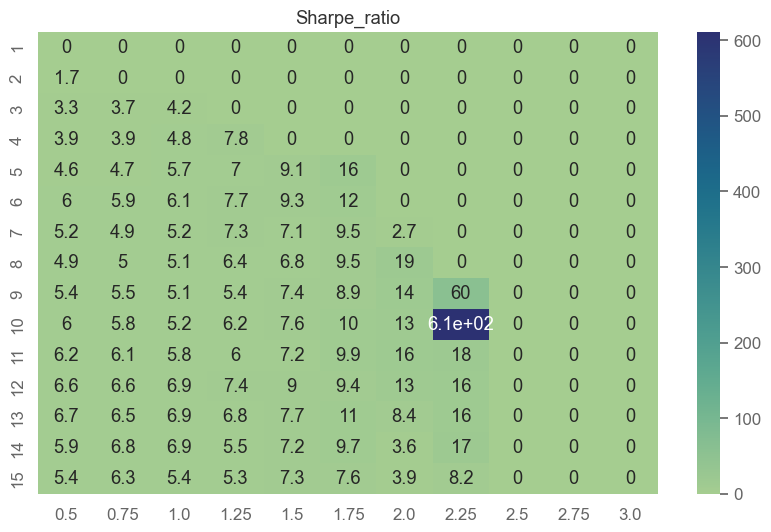

In [118]:
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100

VRP = IV_backtest_data-HV_backtest_data
VRP = VRP.rename('VRP')

result_dict = {}

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        sharpe_ratio = VRP_BB_bound_sharpe(df)
        
        result_dict.update({(rolling_window, std_multiplier):float(sharpe_ratio)})

ser = pd.Series(list(result_dict.values()), index=pd.MultiIndex.from_tuples(result_dict.keys()))
sharpe  = ser.unstack().fillna(0)
sns.heatmap(sharpe, annot = True, cmap = "crest").set_title('Sharpe_ratio')

In [128]:
result_df[result_df['std_multiplier']==1.25].sort_values(by='Freq', ascending=False)

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
36,4,1.25,0.657343,143,4.0,0.00940
47,5,1.25,0.654930,142,5.0,0.01155
58,6,1.25,0.666667,135,6.0,0.01260
69,7,1.25,0.671756,131,7.0,0.01310
80,8,1.25,0.632479,117,7.0,0.01220
91,9,1.25,0.607477,107,8.0,0.01120
102,10,1.25,0.622449,98,8.0,0.01115
113,11,1.25,0.629213,89,9.0,0.01110
124,12,1.25,0.689655,87,9.0,0.01320
135,13,1.25,0.653846,78,10.0,0.01655


In [133]:
# forward_test 
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100
winning_rate_list = []

VRP = IV_forward_data-HV_forward_data
VRP = VRP.rename('VRP')

result_dict = {}
result_dict['rolling_window'] = []
result_dict['std_multiplier'] = []
result_dict['winning_rate'] = []
result_dict['Freq'] = []
result_dict['median_holding_period'] = []
result_dict['volatility_median'] = []

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        
        
        df = pd.concat([HV_forward_data, IV_forward_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        winning_rate, freq, holding_median, volatility_median = VRP_BB_bound(df)
        
        result_dict['rolling_window'].append(rolling_window)
        result_dict['std_multiplier'].append(std_multiplier)
        result_dict['winning_rate'].append(winning_rate)
        result_dict['Freq'].append(freq)
        result_dict['median_holding_period'].append(holding_median)
        result_dict['volatility_median'].append(volatility_median)
            
result_df = pd.DataFrame.from_dict(result_dict)

In [134]:
result_df[result_df['std_multiplier']==1.25].sort_values(by='Freq', ascending=False)

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
36,4,1.25,0.572581,124,5.0,0.01020
47,5,1.25,0.575000,120,5.0,0.01225
58,6,1.25,0.594828,116,6.0,0.01070
69,7,1.25,0.630000,100,7.0,0.01055
80,8,1.25,0.683673,98,7.0,0.01085
91,9,1.25,0.607143,84,8.0,0.01340
102,10,1.25,0.628205,78,10.0,0.01385
113,11,1.25,0.657534,73,11.0,0.01410
124,12,1.25,0.625000,64,12.0,0.01585
135,13,1.25,0.583333,60,11.0,0.01455


Text(0.5, 1.0, 'Sharpe_ratio')

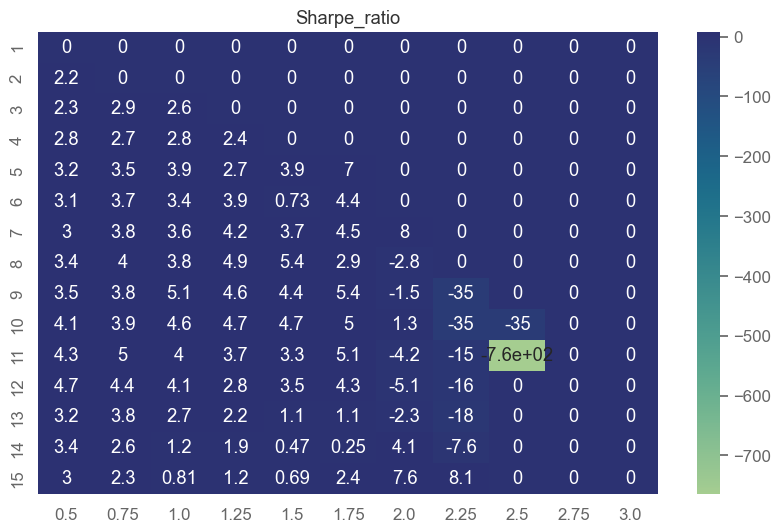

In [122]:
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100

VRP = IV_forward_data-HV_forward_data
VRP = VRP.rename('VRP')

result_dict = {}

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_forward_data.index = pd.to_datetime(HV_forward_data.index)
        HV_forward_data.index = [time.strftime('%Y-%m-%d') for time in HV_forward_data.index]
        df = pd.concat([HV_forward_data, IV_forward_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        sharpe_ratio = VRP_BB_bound_sharpe(df)
        result_dict.update({(rolling_window, std_multiplier):float(sharpe_ratio)})
        
ser = pd.Series(list(result_dict.values()), index=pd.MultiIndex.from_tuples(result_dict.keys()))
sharpe  = ser.unstack().fillna(0)
sns.heatmap(sharpe, annot = True, cmap = "crest").set_title('Sharpe_ratio')